In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import UNET

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [3]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None) -> None:
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.images = os.listdir(image_dir)

    
    def __len__(self):
        return len(self.images)
    

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask[None, :]

In [4]:
model = UNET().to(DEVICE)

In [5]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCH = 10
IMAGE_WIDTH = 240
IMAGE_HEIGHT = 160
NUM_WROKERS = 6
PIN_MEMORY = True

In [6]:
train_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=30),
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
    ToTensorV2()
])

train_set = CarvanaDataset(image_dir="../datasets/Carvana/train",
                           mask_dir="../datasets/Carvana/train_masks",
                           transforms=train_transforms)

val_set = CarvanaDataset(image_dir="../datasets/Carvana/val",
                           mask_dir="../datasets/Carvana/val_masks",
                           transforms=val_transforms)

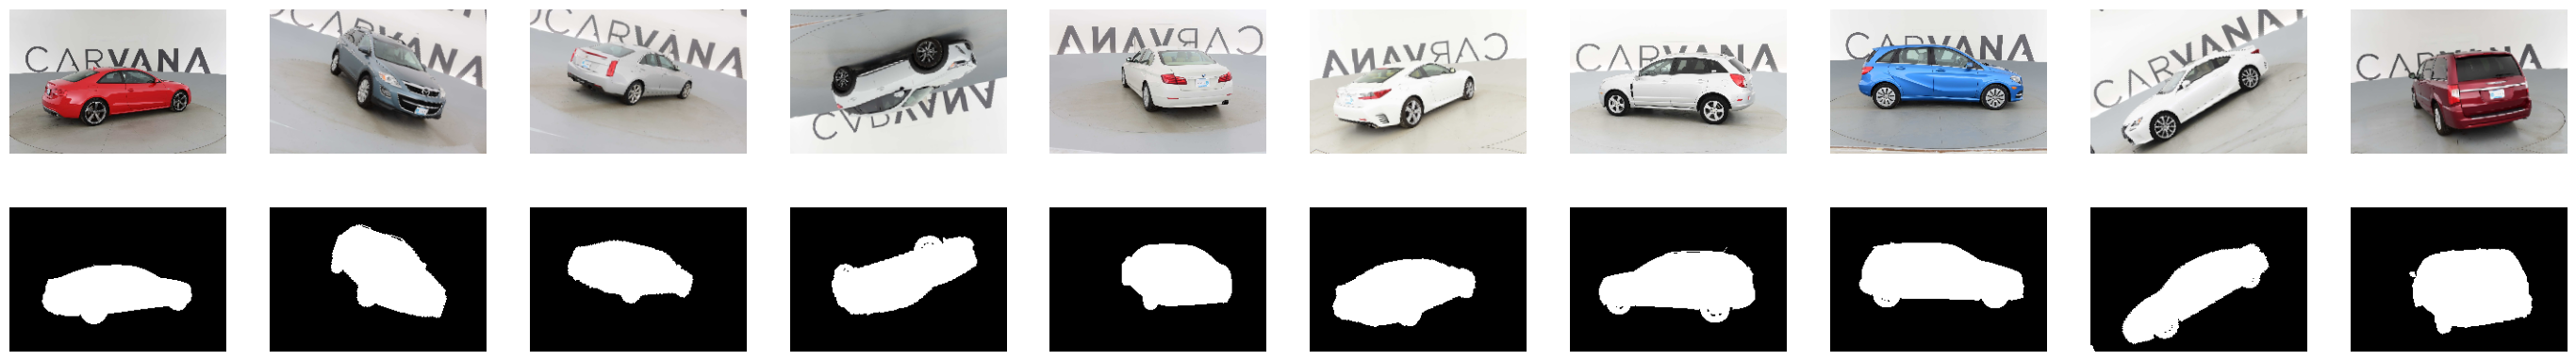

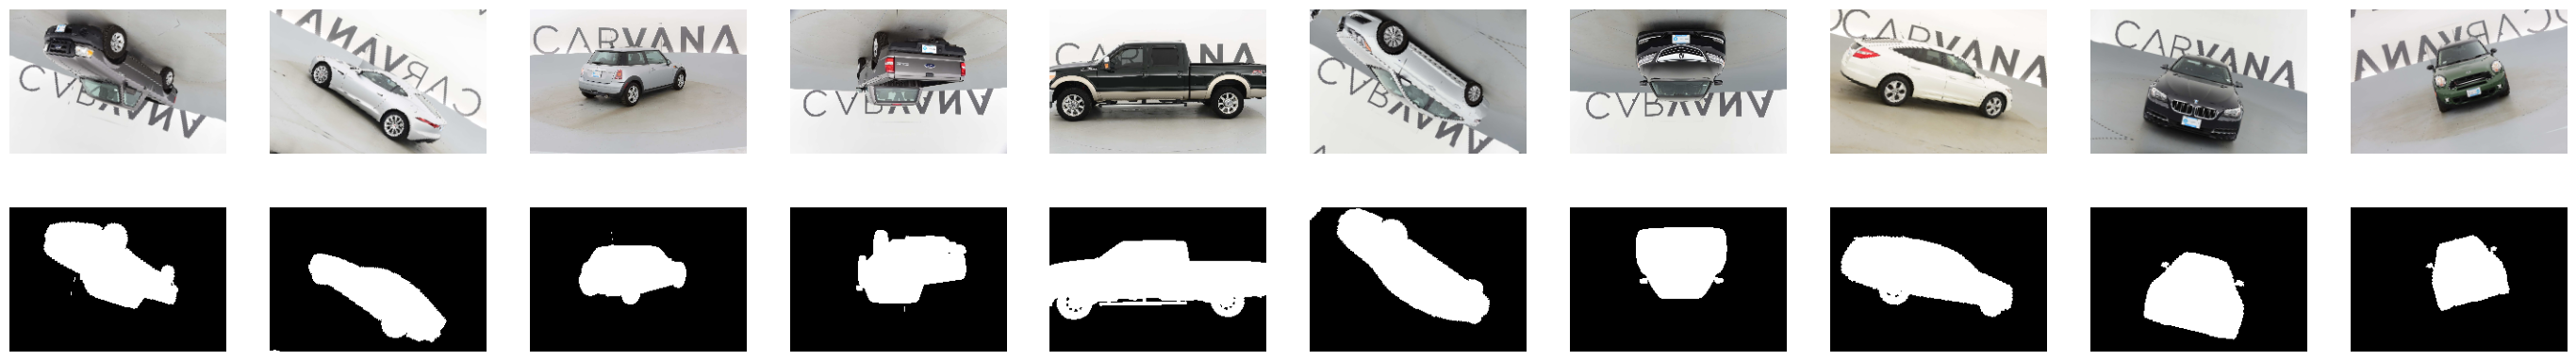

In [7]:
for data_split in [train_set, val_set]:
    idx = np.random.randint(data_split.__len__(), size=10)
    fig, axs = plt.subplots(2, 10, figsize=(35, 5))

    for ax0, ax1, i in zip(axs[0], axs[1], idx):
        img, mask = train_set.__getitem__(i)
        ax0.imshow(img.permute(1, 2, 0))
        ax0.axis(False)

        ax1.imshow(mask.permute(1, 2, 0), cmap="gray")
        ax1.axis(False)

    plt.show()

In [8]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY, drop_last=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY, drop_last=True)

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [38]:
train_loss = []
min_loss = float('inf')

for epoch in range(NUM_EPOCH):

    total_loss = 0

    # with torch.is_
    # training loop
    for image, mask in tqdm(train_loader, desc=f'Train epoch: {epoch + 1}'):
        image, mask = image.to(DEVICE), mask.to(DEVICE)
        out = model(image)

        loss = criterion(out, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    # validation loop
    total_loss = 0
    with torch.no_grad():
        for image, mask in tqdm(val_loader, desc=f'Validation epoch: {epoch + 1}'):
            image, mask = image.to(DEVICE), mask.to(DEVICE)
            out = model(image)
            loss = criterion(out, mask)
            total_loss += loss.item()
        
        val_loss = total_loss / len(val_loader)
        print(f'Validation loss: {val_loss:.4f}')

        if val_loss < min_loss:
            min_loss = val_loss
            torch.save(model.state_dict(), "./best_model.pth")
            torch.save(optimizer.state_dict(), "./optimizer_states.pth")

Train epoch: 1:   0%|          | 1/322 [00:11<1:01:52, 11.57s/it]

## Mask generation

In [11]:
model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

In [37]:
outputs, inputs, ground_truth = [], [], []
with torch.no_grad():
    for image, mask in tqdm(val_loader):
        image, mask = image.to(DEVICE), mask.to(DEVICE)
        out = torch.sigmoid(model(image)).squeeze(0).cpu()
        outputs.extend(out)
        inputs.extend(image)
        ground_truth.extend(mask.squeeze(0).cpu())

100%|██████████| 15/15 [01:03<00:00,  4.25s/it]


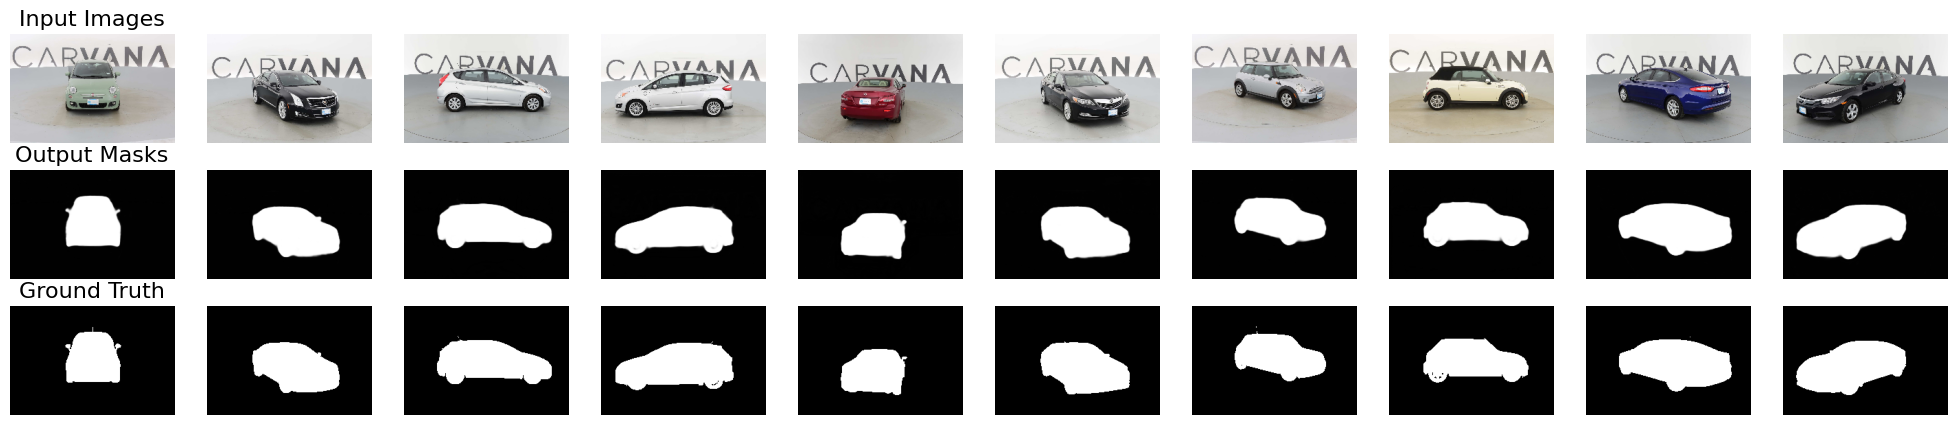

In [65]:
idxs = np.random.randint(0, len(inputs), 10)
fig, axs = plt.subplots(3, 10, figsize=(25, 5))

axs[0, 0].set_title("Input Images", loc='center', fontsize=16)
axs[1, 0].set_title("Output Masks", loc='center', fontsize=16)
axs[2, 0].set_title("Ground Truth", loc='center', fontsize=16)

for i in range(10):
    idx = idxs[i]
    axs[0, i].imshow(inputs[idx].permute(1, 2, 0))
    axs[0, i].axis(False)

    axs[1, i].imshow(outputs[idx].permute(1, 2, 0), cmap="gray")
    axs[1, i].axis(False)

    axs[2, i].imshow(ground_truth[idx].permute(1, 2, 0), cmap="gray")
    axs[2, i].axis(False)

plt.show()